# Pathway analysis and visualization

In [610]:
library(dplyr)
library(ggplot2)
library(viridis)
library(pheatmap)

Loading required package: viridisLite



# Liver

In [6]:
SETS_DIR =  "/mnt/ibm_lg/covid_tissue_atlas/results/gene_sets/pathfindr/"

this_sample = 'liver'
db_list <- c('Reactome', 'KEGG', 'BioCarta', 'GO-All')
direction = 'up'
gene_sets = list() 
for(d in db_list){ 
	load( paste0(SETS_DIR, this_sample, '/all_cell_types_',d, '_' ,direction, '.rda') ) 
  tissue_pathways$database = d
	gene_sets[[d]] = tissue_pathways
}

path_df  = do.call(rbind, gene_sets) 

path_df %>% dplyr::filter(highest_p <0.0001 ) %>% group_by(cell_type, database)  %>% 
	top_n(n = -5, wt = highest_p)  %>% 
	select(Term_Description, cell_type, Fold_Enrichment, highest_p, support, database) %>% 
	arrange(highest_p) -> ranked_paths 

Significant Pathways by database

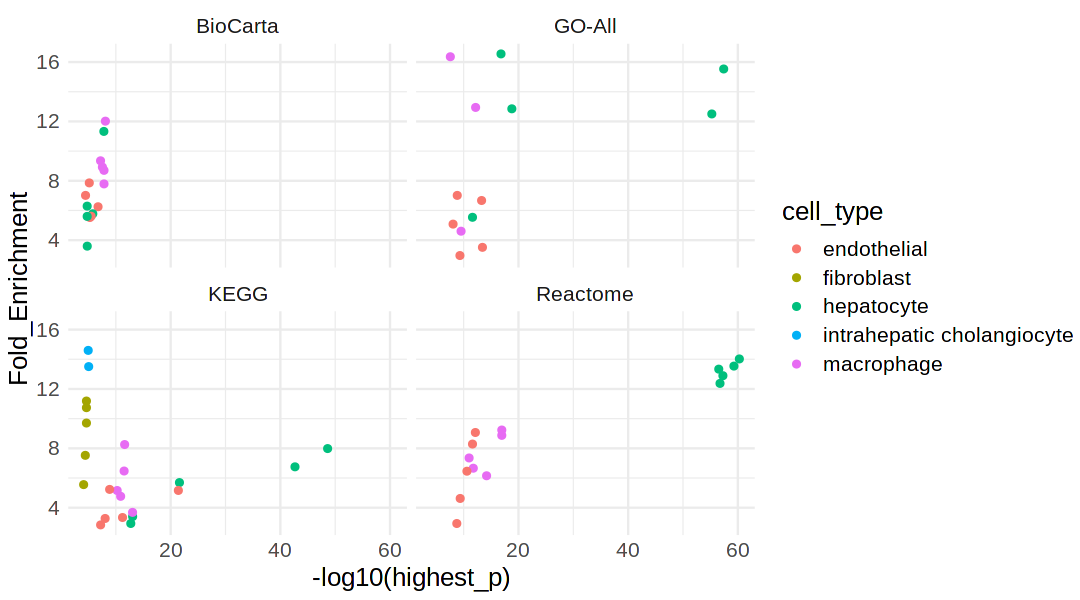

In [13]:
options(repr.plot.width=9, repr.plot.height=5)


ranked_paths %>% dplyr::filter(Fold_Enrichment <20)  %>% ggplot(aes(x = -log10(highest_p), y = Fold_Enrichment, color = cell_type)) + 
    geom_point() + theme_minimal() + theme(text =element_text(size =15)) +facet_wrap(~database)

## Test general functions 
Here we seek to focus the pathwayanalysis to a specific biological questions. For the liver, we are interested in Insuling signaling and signaling in general. 

In [552]:
source("/mnt/ibm_lg/covid_tissue_atlas/CovidTissueAtlas/cta_utils/pathway_analysis.R")

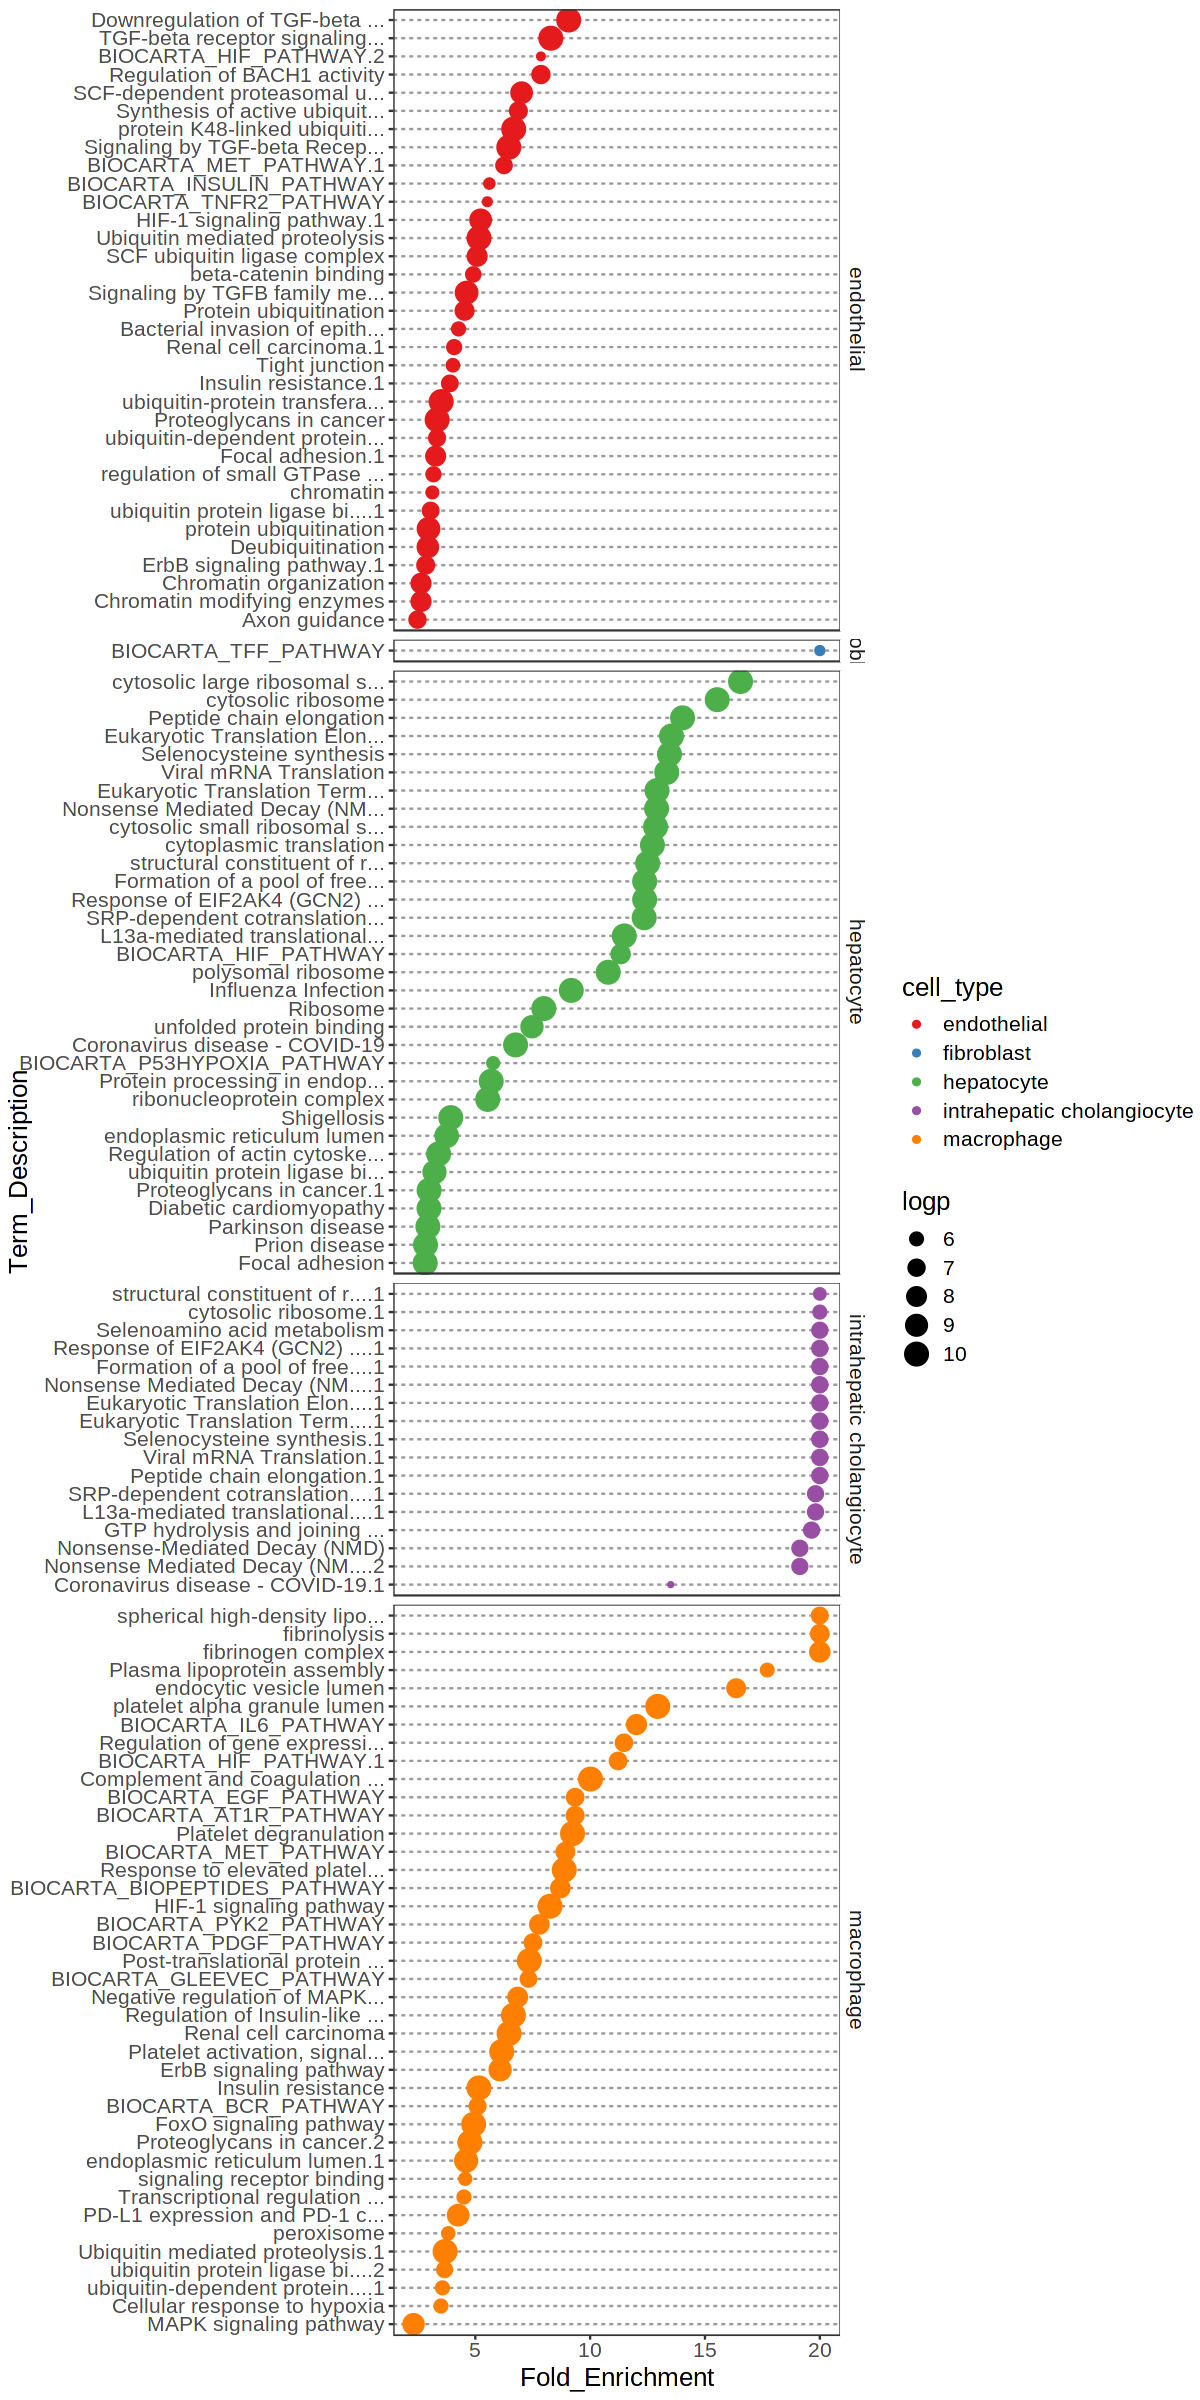

In [553]:
options(repr.plot.width=10, repr.plot.height=20)
plotTopPathwaysOrgan( path_df, min_pval = 0.00001, max_logp = 10, max_FC =20)

In [554]:
ranked_paths_organ <- filterTopPathwaysOrgan(path_df, top_pathways = 100, min_pval =0.01, minFC = 2, min_genes_used = 3, direction = 'up')
ranked_paths_organ %>% group_by(cell_type, database) %>% count %>% arrange(cell_type,desc(n))

cell_type,database,n
<chr>,<chr>,<int>
endothelial,Reactome,333
endothelial,GO-All,151
endothelial,KEGG,96
endothelial,BioCarta,19
fibroblast,KEGG,4
fibroblast,GO-All,1
hepatocyte,Reactome,482
hepatocyte,GO-All,272
hepatocyte,KEGG,118


In [563]:
FIG_DIR = paste('/mnt/ibm_lg/covid_tissue_atlas/figures/figure2/', this_sample,'/',sep="")
FIG_DIR

[1] "/mnt/ibm_lg/covid_tissue_atlas/figures/figure2/liver/"

## Final figure for manuscript

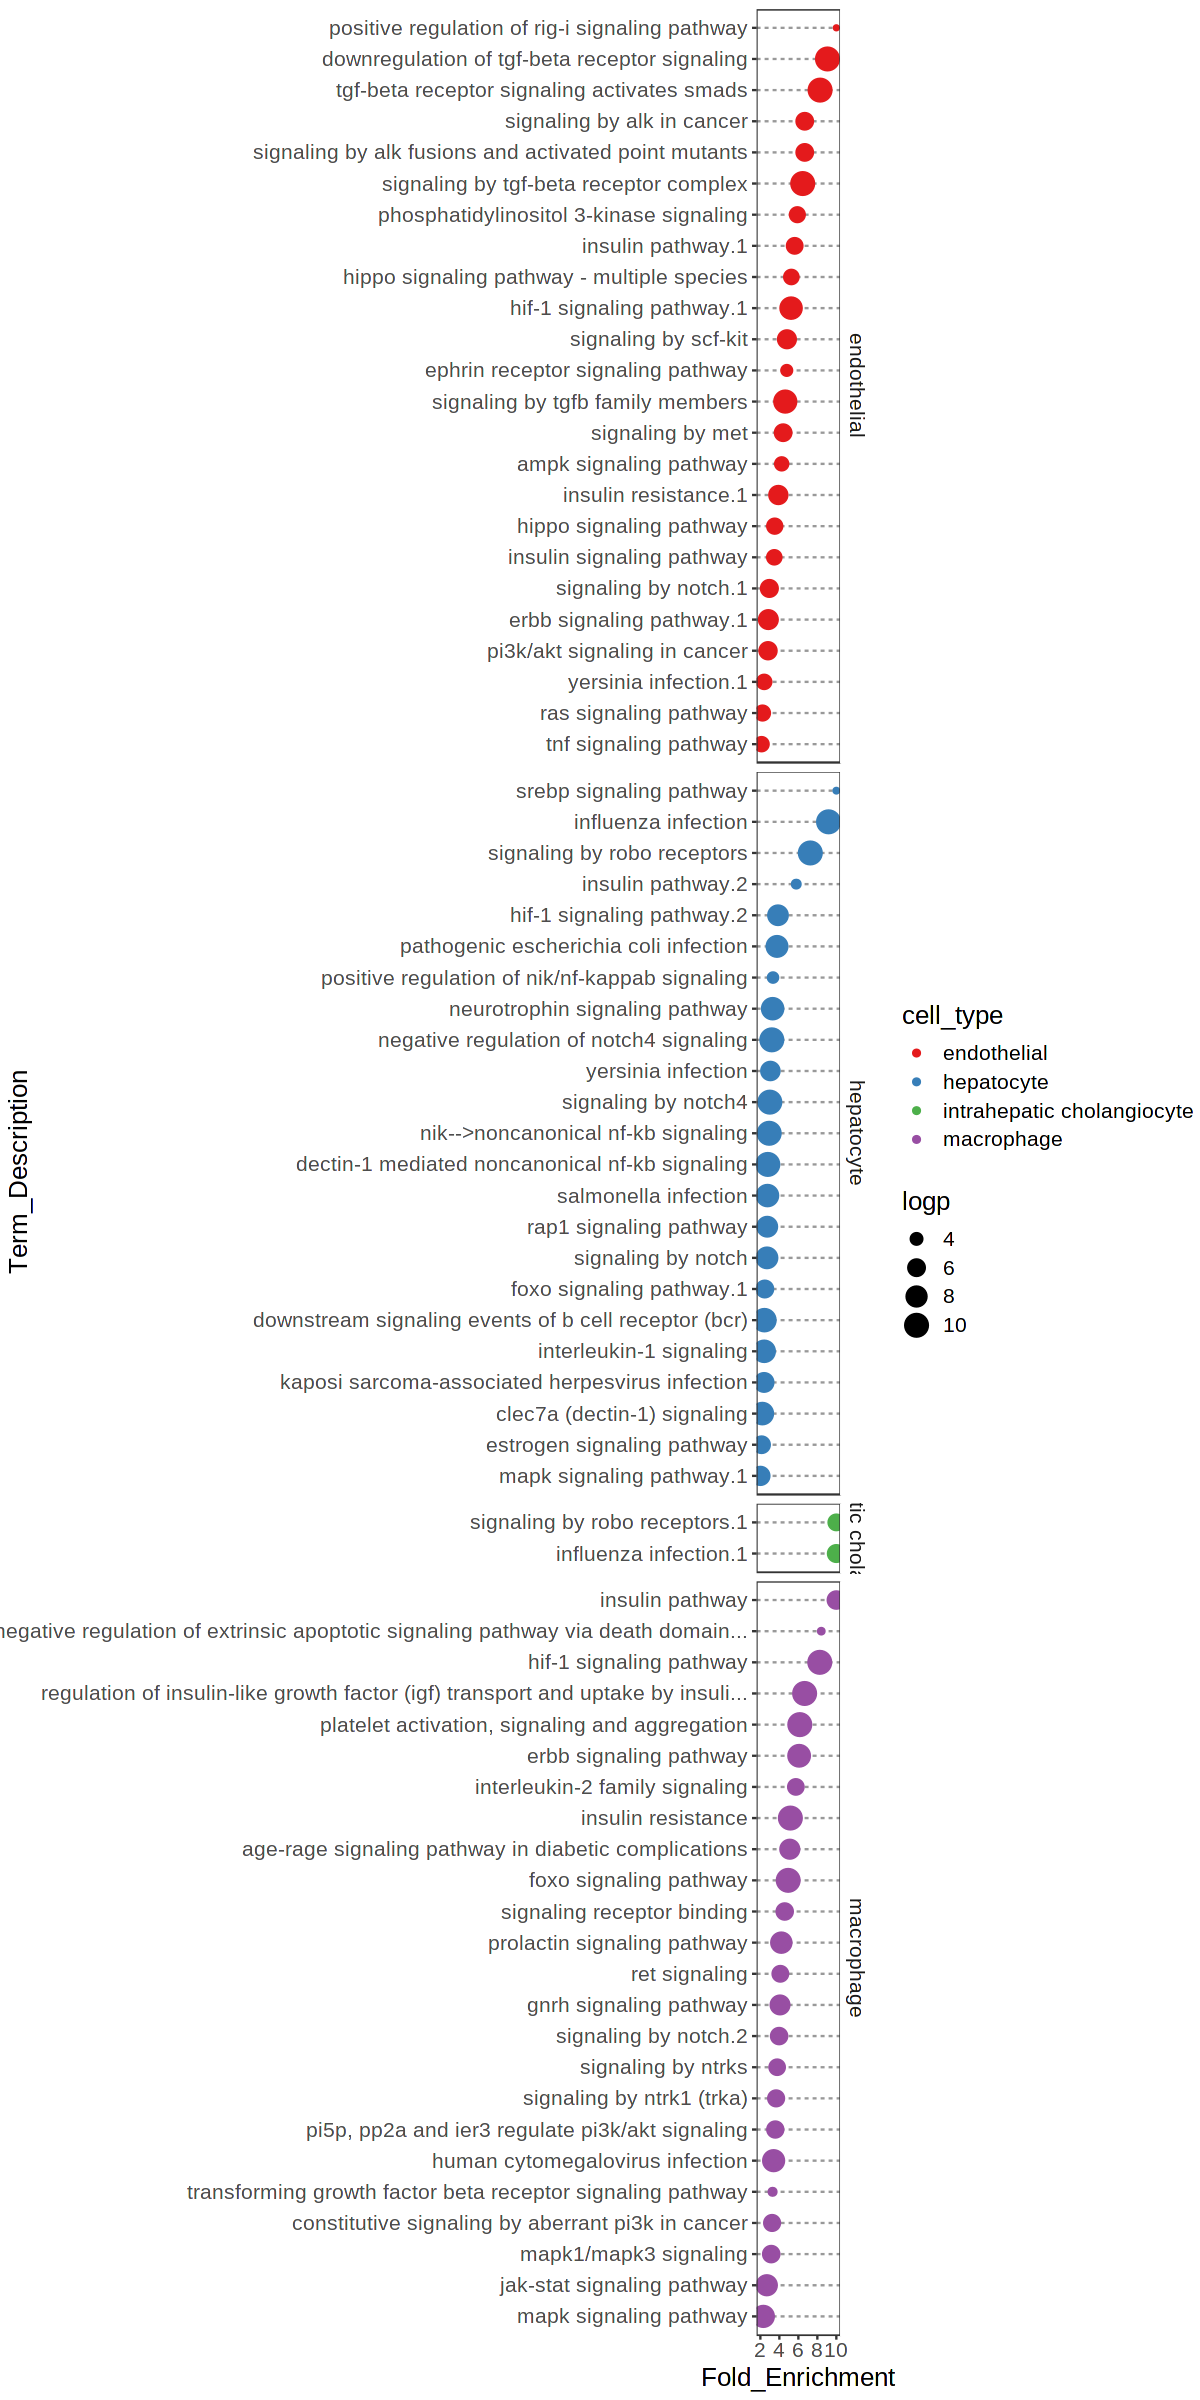

In [568]:
options(repr.plot.width=10, repr.plot.height=20)


raw_names <- ranked_paths_organ%>% pull(Term_Description) 

simple_names <- sapply(raw_names, function(x){
                                    if (grepl(x, pattern = "BIOCARTA")){ 
                                        return(str_split(x, "_", simplify= T)[-1] %>% paste(collapse = " ")) 
                                    }else{
                                        return(x)
                                    } } )
simple_names <- tolower(simple_names)
ranked_paths_organ$reference_pathway <- ranked_paths_organ$Term_Description
ranked_paths_organ$Term_Description <- simple_names

#term_grep_pattern = 'insulin|infection|signaling|wnt|catenin|foxo|notch|bmp|vegf|egf|gfg|eph|interleu|il-|'
term_grep_pattern = 'insulin|infection|signaling'

which_direction = 'up'
n_pathways = 20


pathway_hits <- ranked_paths_organ %>% dplyr::filter(grepl(Term_Description, pattern = term_grep_pattern, ignore.case =T)) %>% 
                    arrange(cell_type) %>%  dplyr::filter(n_genes_used > 2, highest_p < 1e-3) 

pathway_hits %>% plotTopPathwaysOrgan(max_logp=10, max_FC = 10,max_name_length = 80)


ggsave(filename = paste0(FIG_DIR , this_sample, 'PathwaysUP_cov19.pdf'), width = 10, height = 20, dpi = 300)

### Heatmap with all genes up/down

In [581]:
SETS_DIR =  "/mnt/ibm_lg/covid_tissue_atlas/results/gene_sets/pathfindr/"


load_pathways_UpDown<- function(this_sample = 'liver'){
    db_list <- c('Reactome', 'KEGG', 'BioCarta', 'GO-All')
    out_paths = data.frame() 
    
    for(direction in c('up', 'down')){
        gene_sets = list() 
        for(d in db_list){ 
            load( paste0(SETS_DIR, this_sample, '/all_cell_types_',d, '_' ,direction, '.rda') ) 
          tissue_pathways$database = d
            gene_sets[[d]] = tissue_pathways
        }

        path_df  = do.call(rbind, gene_sets) 

        path_df %>% dplyr::filter(highest_p <0.0001 ) %>% group_by(cell_type, database)  %>% 
            top_n(n = -5, wt = highest_p)  %>% 
            select(Term_Description, cell_type, Fold_Enrichment, highest_p, support, database) %>% 
            arrange(highest_p) -> ranked_paths 

        ranked_paths_organ <- filterTopPathwaysOrgan(path_df, top_pathways = 100, min_pval =0.01, minFC = 2, min_genes_used = 3, direction = 'up')

        ranked_paths_organ$direction = direction

        out_paths = rbind(out_paths, ranked_paths_organ )        
    }
    
    
    raw_names <- out_paths%>% pull(Term_Description) 

    simple_names <- sapply(raw_names, function(x){
                                        if (grepl(x, pattern = "BIOCARTA")){ 
                                            return(str_split(x, "_", simplify= T)[-1] %>% paste(collapse = " ")) 
                                        }else{
                                            return(x)
                                        } } )
    simple_names <- tolower(simple_names)
    out_paths$reference_pathway <- out_paths$Term_Description
    out_paths$Term_Description <- simple_names
    return(out_paths)
}

### Heatmap with all genes in the top/bottom pathways 

In [ ]:
organ_allupdown <- load_pathways_UpDown('liver')

#term_grep_pattern = 'insulin|infection|signaling|wnt|catenin|foxo|notch|bmp|vegf|egf|gfg|eph|interleu|il-|'
term_grep_pattern = 'insulin|infection|signaling'

which_direction = 'up'
n_pathways = 20


pathway_hits <- organ_allupdown %>% dplyr::filter(grepl(Term_Description, pattern = term_grep_pattern, ignore.case =T)) %>% 
                    arrange(cell_type) %>%  dplyr::filter(n_genes_used > 2, highest_p < 1e-3) 

In [641]:

# Read DGE results from MAST
DGE_FILE = '/mnt/ibm_lg/covid_tissue_atlas/results/DGE/MAST/all_celltypes_DGE_ngenescovar_Nov_MAST.csv'
dge_df = read.csv(DGE_FILE)

# In heart, remove neurons from final figure 
dge_df <- dge_df %>% dplyr::filter(cell_type !='neurons')

# Filter tissue and cell type of interest 
dge_df %>% filter(tissue == this_sample) -> tissue_df
#tissue_df$pval <- p.adjust(tissue_df$pval, method = 'bonferroni')
tissue_df %>% dplyr::filter(pval<0.0000001) -> tissue_df

In [705]:
# match the genes in a given pathway set with the individual DE values
getGeneListsOrgan <- function(pathway_hits = data.frame(), DE_df = data.frame() ){
    cell_types <- pathway_hits$cell_type %>% unique 
    genes_lists = list()
    
    for(t in cell_types){
        gene_lists <- pathway_hits %>% dplyr::filter(cell_type ==t) %>% pull(genes)
        tissue_genes <- str_split(paste(gene_lists, collapse =",", sep = "") , ",")[[1]] %>% trimws() %>% unique 

        genes_lists[[t]] <-  data.frame(cell_type = t, gene = tissue_genes)

        }
        genes_df <- do.call(rbind, genes_lists)
        row.names(genes_df) <- 1:dim(genes_df)[1]
    
        FC_matrix <- genes_df %>% left_join(DE_df, by =c('gene', 'cell_type')) %>% select(cell_type, gene, log2fc) %>% 
                tidyr::spread(key = gene, value = log2fc, fill = 0)
        tissue_rows <- FC_matrix$cell_type
        x <- FC_matrix %>% dplyr::select(-cell_type) %>% as.matrix()
        row.names(x) <- tissue_rows
    
    return(x)
}

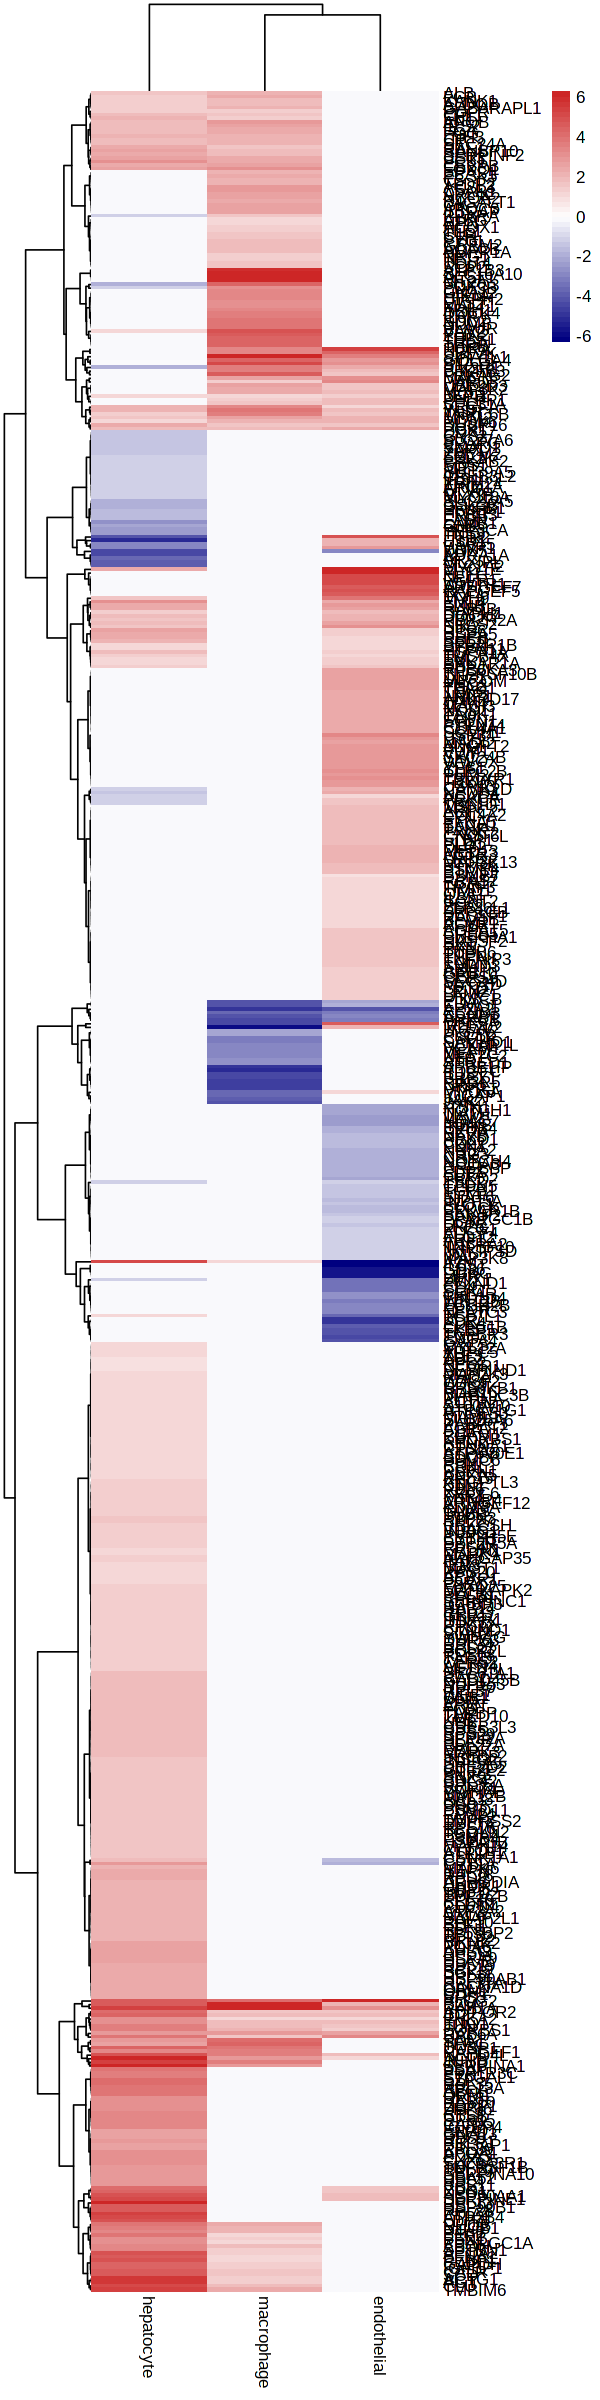

In [668]:
options(repr.plot.width=5, repr.plot.height=20)

select_celltypes = c('hepatocyte','macrophage','endothelial') 
x<- getGeneListsOrgan(pathway_hits, tissue_df) 
x<- x[select_celltypes,colSums(abs(x))>0]
cutoff <- min(max(x), abs(min(x)))
x[x<-cutoff] <- -cutoff
x[x>cutoff] <- cutoff
p <- pheatmap(t(x),  col = colorRampPalette(c("navy", "white", "firebrick3"))(50), clustering_method = 'ward.D2')

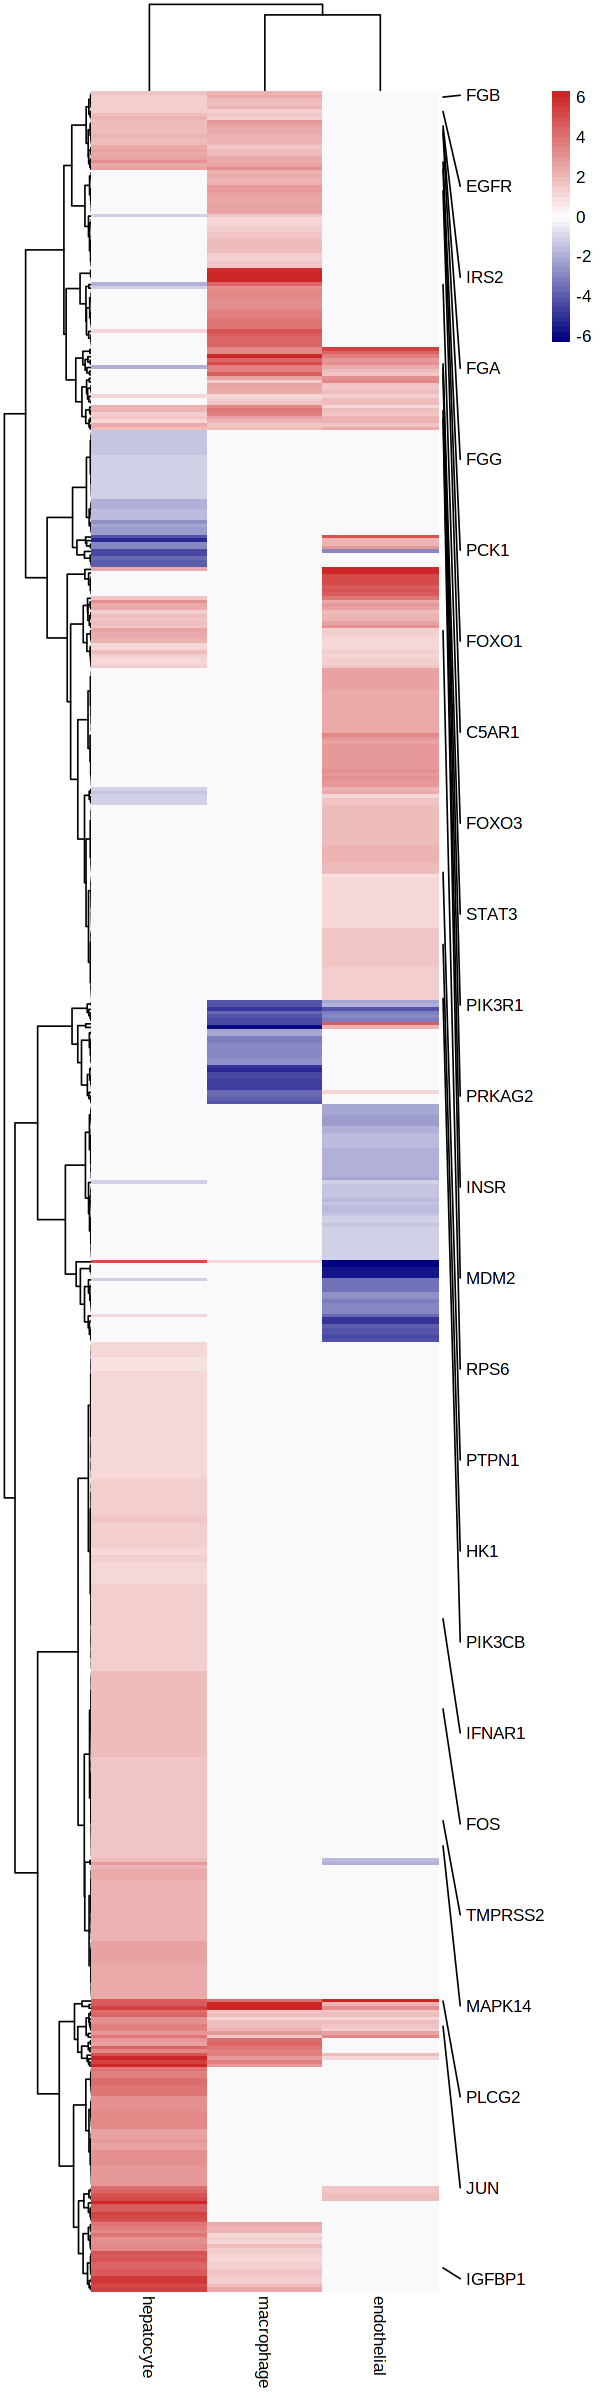

In [670]:
library(grid)
kept.labels = c('INSR','IGFBP1' ,'PRKAG2', 'MDM2', 'INSR', 'IRS2', 'PIK3CB', 
                'PIK3R1', 'FOXO1', 'FOXO3', 'STAT3', 'EGFR', 'MAP2K1', 'MAPK14', 'PCK1',
               'INSR', 'HK1', 'PRKAG2', 
                'RPS6', 'PTPN1',
               'TMPRSS2','EGFR', 'PLCG2', 'MAPK14', 'FOS', 'JUN', 'IFNAR1', 'C5AR1', 'CFB', 'C8G', 'MASP1', 'FGA', 'FGB', 'FGG')
kept.labels = kept.labels[kept.labels %in% colnames(x)]
p1 = add.flag(p, kept.labels, 0.5)

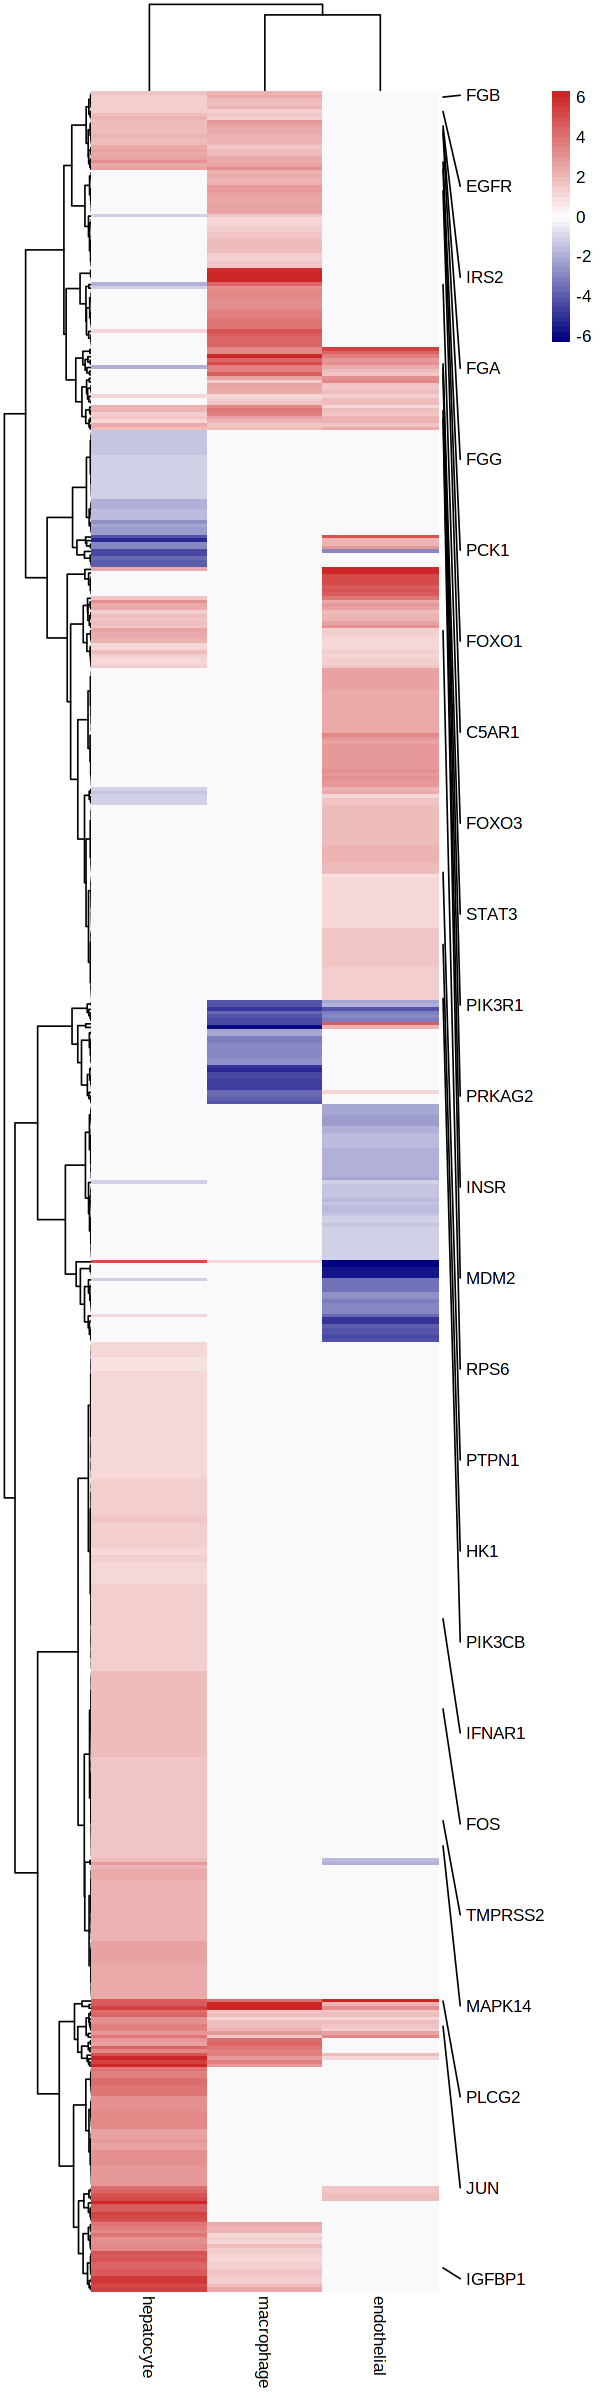

In [675]:
grid.draw(p1)

In [677]:
ggsave(filename=paste(FIG_DIR, "heatmap_topgenesLiver.pdf", sep =""), plot=p1,
      width = 7, height = 20 )

In [653]:
add.flag <- function(pheatmap,
                     kept.labels,
                     repel.degree) {

  # repel.degree = number within [0, 1], which controls how much 
  #                space to allocate for repelling labels.
  ## repel.degree = 0: spread out labels over existing range of kept labels
  ## repel.degree = 1: spread out labels over the full y-axis

  heatmap <- pheatmap$gtable

  new.label <- heatmap$grobs[[which(heatmap$layout$name == "row_names")]] 

  # keep only labels in kept.labels, replace the rest with ""
  new.label$label <- ifelse(new.label$label %in% kept.labels, 
                            new.label$label, "")

  # calculate evenly spaced out y-axis positions
  repelled.y <- function(d, d.select, k = repel.degree){
    # d = vector of distances for labels
    # d.select = vector of T/F for which labels are significant

    # recursive function to get current label positions
    # (note the unit is "npc" for all components of each distance)
    strip.npc <- function(dd){
      if(!"unit.arithmetic" %in% class(dd)) {
        return(as.numeric(dd))
      }

      d1 <- strip.npc(dd$arg1)
      d2 <- strip.npc(dd$arg2)
      fn <- dd$fname
      return(lazyeval::lazy_eval(paste(d1, fn, d2)))
    }

    full.range <- sapply(seq_along(d), function(i) strip.npc(d[i]))
    selected.range <- sapply(seq_along(d[d.select]), function(i) strip.npc(d[d.select][i]))

    return(unit(seq(from = max(selected.range) + k*(max(full.range) - max(selected.range)),
                    to = min(selected.range) - k*(min(selected.range) - min(full.range)), 
                    length.out = sum(d.select)), 
                "npc"))
  }
  new.y.positions <- repelled.y(new.label$y,
                                d.select = new.label$label != "")
  new.flag <- segmentsGrob(x0 = new.label$x,
                           x1 = new.label$x + unit(0.15, "npc"),
                           y0 = new.label$y[new.label$label != ""],
                           y1 = new.y.positions)

  # shift position for selected labels
  new.label$x <- new.label$x + unit(0.2, "npc")
  new.label$y[new.label$label != ""] <- new.y.positions

  # add flag to heatmap
  heatmap <- gtable::gtable_add_grob(x = heatmap,
                                   grobs = new.flag,
                                   t = 4, 
                                   l = 4
  )

  # replace label positions in heatmap
  heatmap$grobs[[which(heatmap$layout$name == "row_names")]] <- new.label

  # plot result
  grid.newpage()
  grid.draw(heatmap)

  # return a copy of the heatmap invisibly
  invisible(heatmap)
}

# Heart

In [680]:
SETS_DIR =  "/mnt/ibm_lg/covid_tissue_atlas/results/gene_sets/pathfindr/"

this_sample = 'heart'
db_list <- c('Reactome', 'KEGG', 'BioCarta', 'GO-All')
direction = 'up'
gene_sets = list() 
for(d in db_list){ 
	load( paste0(SETS_DIR, this_sample, '/all_cell_types_',d, '_' ,direction, '.rda') ) 
  tissue_pathways$database = d
	gene_sets[[d]] = tissue_pathways
}

path_df  = do.call(rbind, gene_sets) 

path_df %>% dplyr::filter(highest_p <0.0001 ) %>% group_by(cell_type, database)  %>% 
	top_n(n = -5, wt = highest_p)  %>% 
	select(Term_Description, cell_type, Fold_Enrichment, highest_p, support, database) %>% 
	arrange(highest_p) -> ranked_paths 

Significant Pathways by database

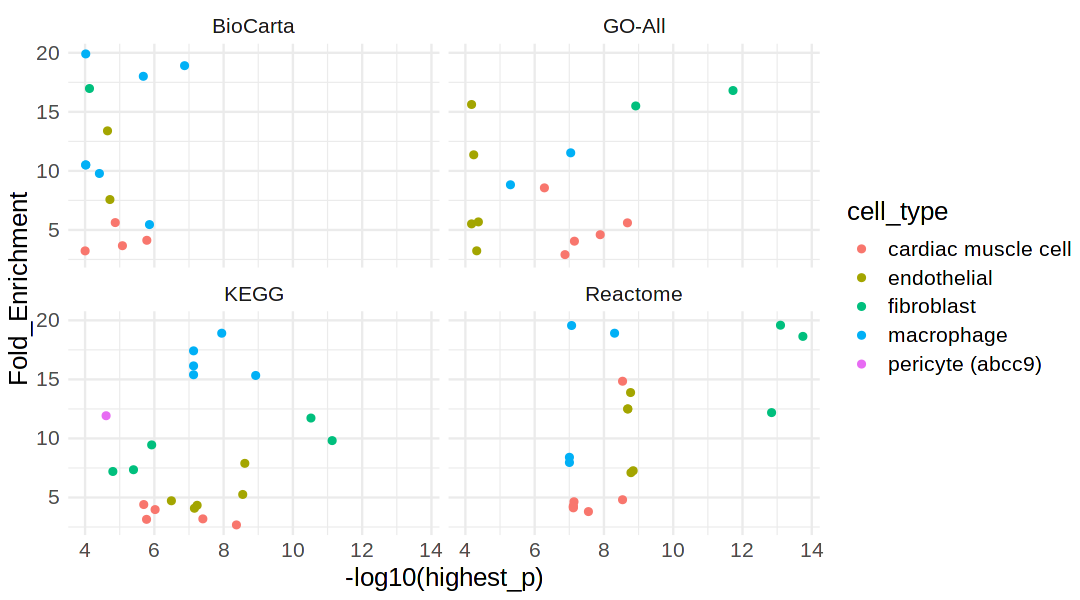

In [681]:
options(repr.plot.width=9, repr.plot.height=5)


ranked_paths %>% dplyr::filter(Fold_Enrichment <20)  %>% ggplot(aes(x = -log10(highest_p), y = Fold_Enrichment, color = cell_type)) + 
    geom_point() + theme_minimal() + theme(text =element_text(size =15)) +facet_wrap(~database)

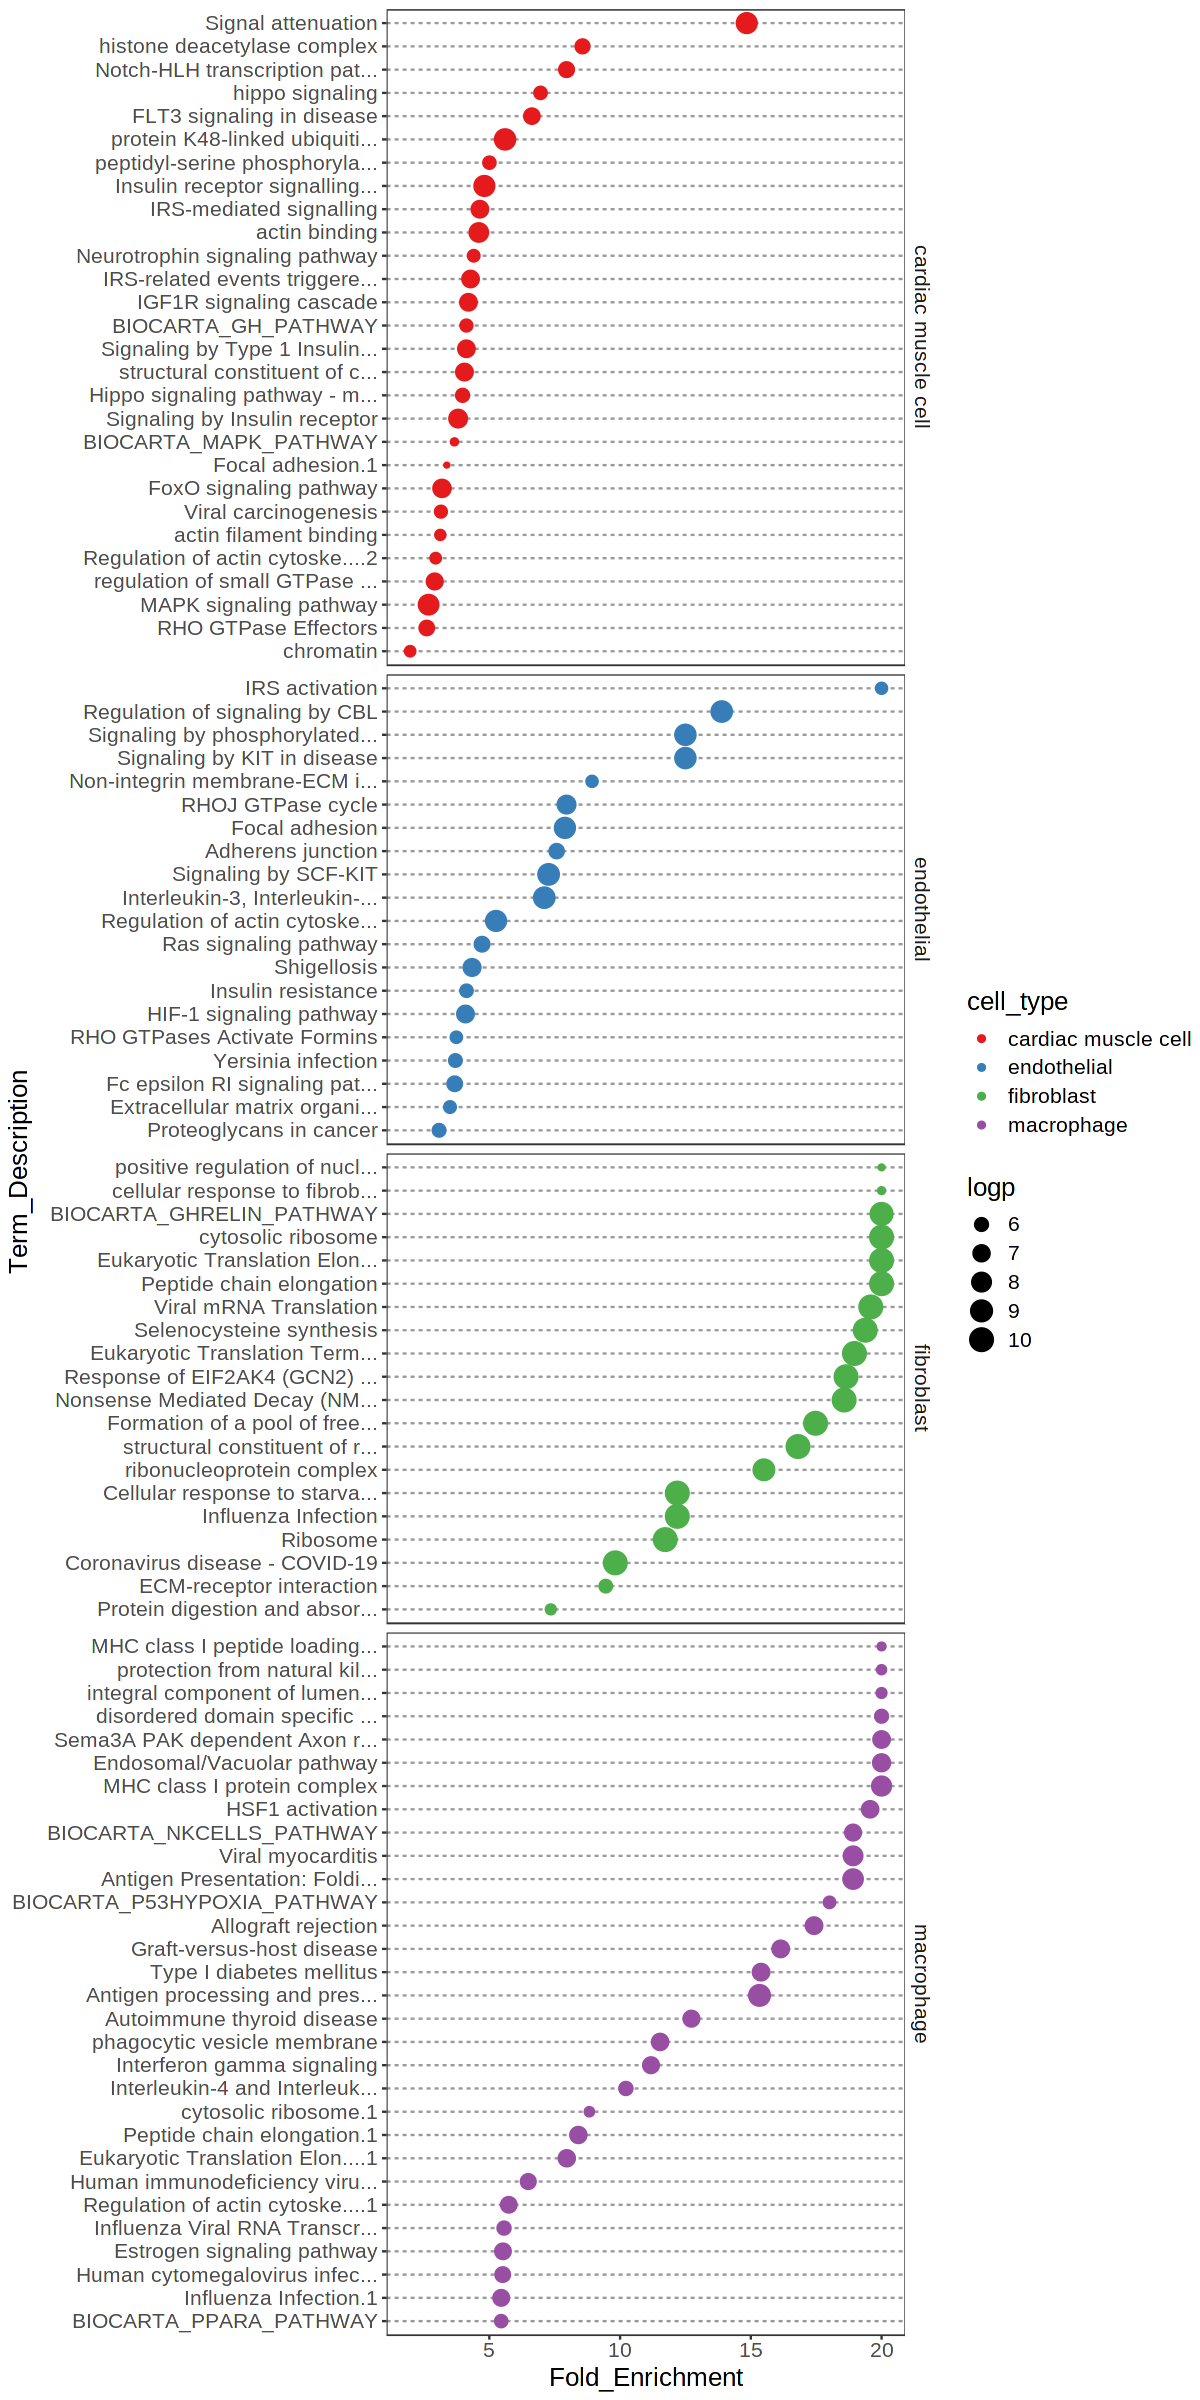

In [688]:
options(repr.plot.width=10, repr.plot.height=20)
plotTopPathwaysOrgan( path_df, min_pval = 0.00001, max_logp = 10, max_FC =20)

In [690]:
path_df %>% dplyr::filter(grepl(Term_Description , pattern= 'hippo'))

,ID,Term_Description,Fold_Enrichment,occurrence,support,lowest_p,highest_p,Up_regulated,Down_regulated,cell_type,database
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
GO-All.17,GO:0035329,hippo signaling,6.958298,6,0.005226243,0.0000013220,0.000001322,"STK3, WWTR1, MOB1B",,cardiac muscle cell,GO-All
GO-All.208,GO:0035329,hippo signaling,11.717134,7,0.005000000,0.0003566765,0.002857114,"STK3, TEAD4, WWTR1",,endothelial,GO-All


In [691]:
ranked_paths_organ <- filterTopPathwaysOrgan(path_df, top_pathways = 100, min_pval =0.01, minFC = 2, min_genes_used = 2, direction = 'up')
ranked_paths_organ %>% group_by(cell_type, database) %>% count %>% arrange(cell_type,desc(n))

cell_type,database,n
<chr>,<chr>,<int>
cardiac muscle cell,Reactome,232
cardiac muscle cell,GO-All,121
cardiac muscle cell,KEGG,68
cardiac muscle cell,BioCarta,25
endothelial,Reactome,132
endothelial,KEGG,101
endothelial,GO-All,79
endothelial,BioCarta,4
fibroblast,Reactome,100


In [692]:
FIG_DIR = paste('/mnt/ibm_lg/covid_tissue_atlas/figures/figure2/', this_sample,'/',sep="")
FIG_DIR

[1] "/mnt/ibm_lg/covid_tissue_atlas/figures/figure2/heart/"

## Final figure for manuscript

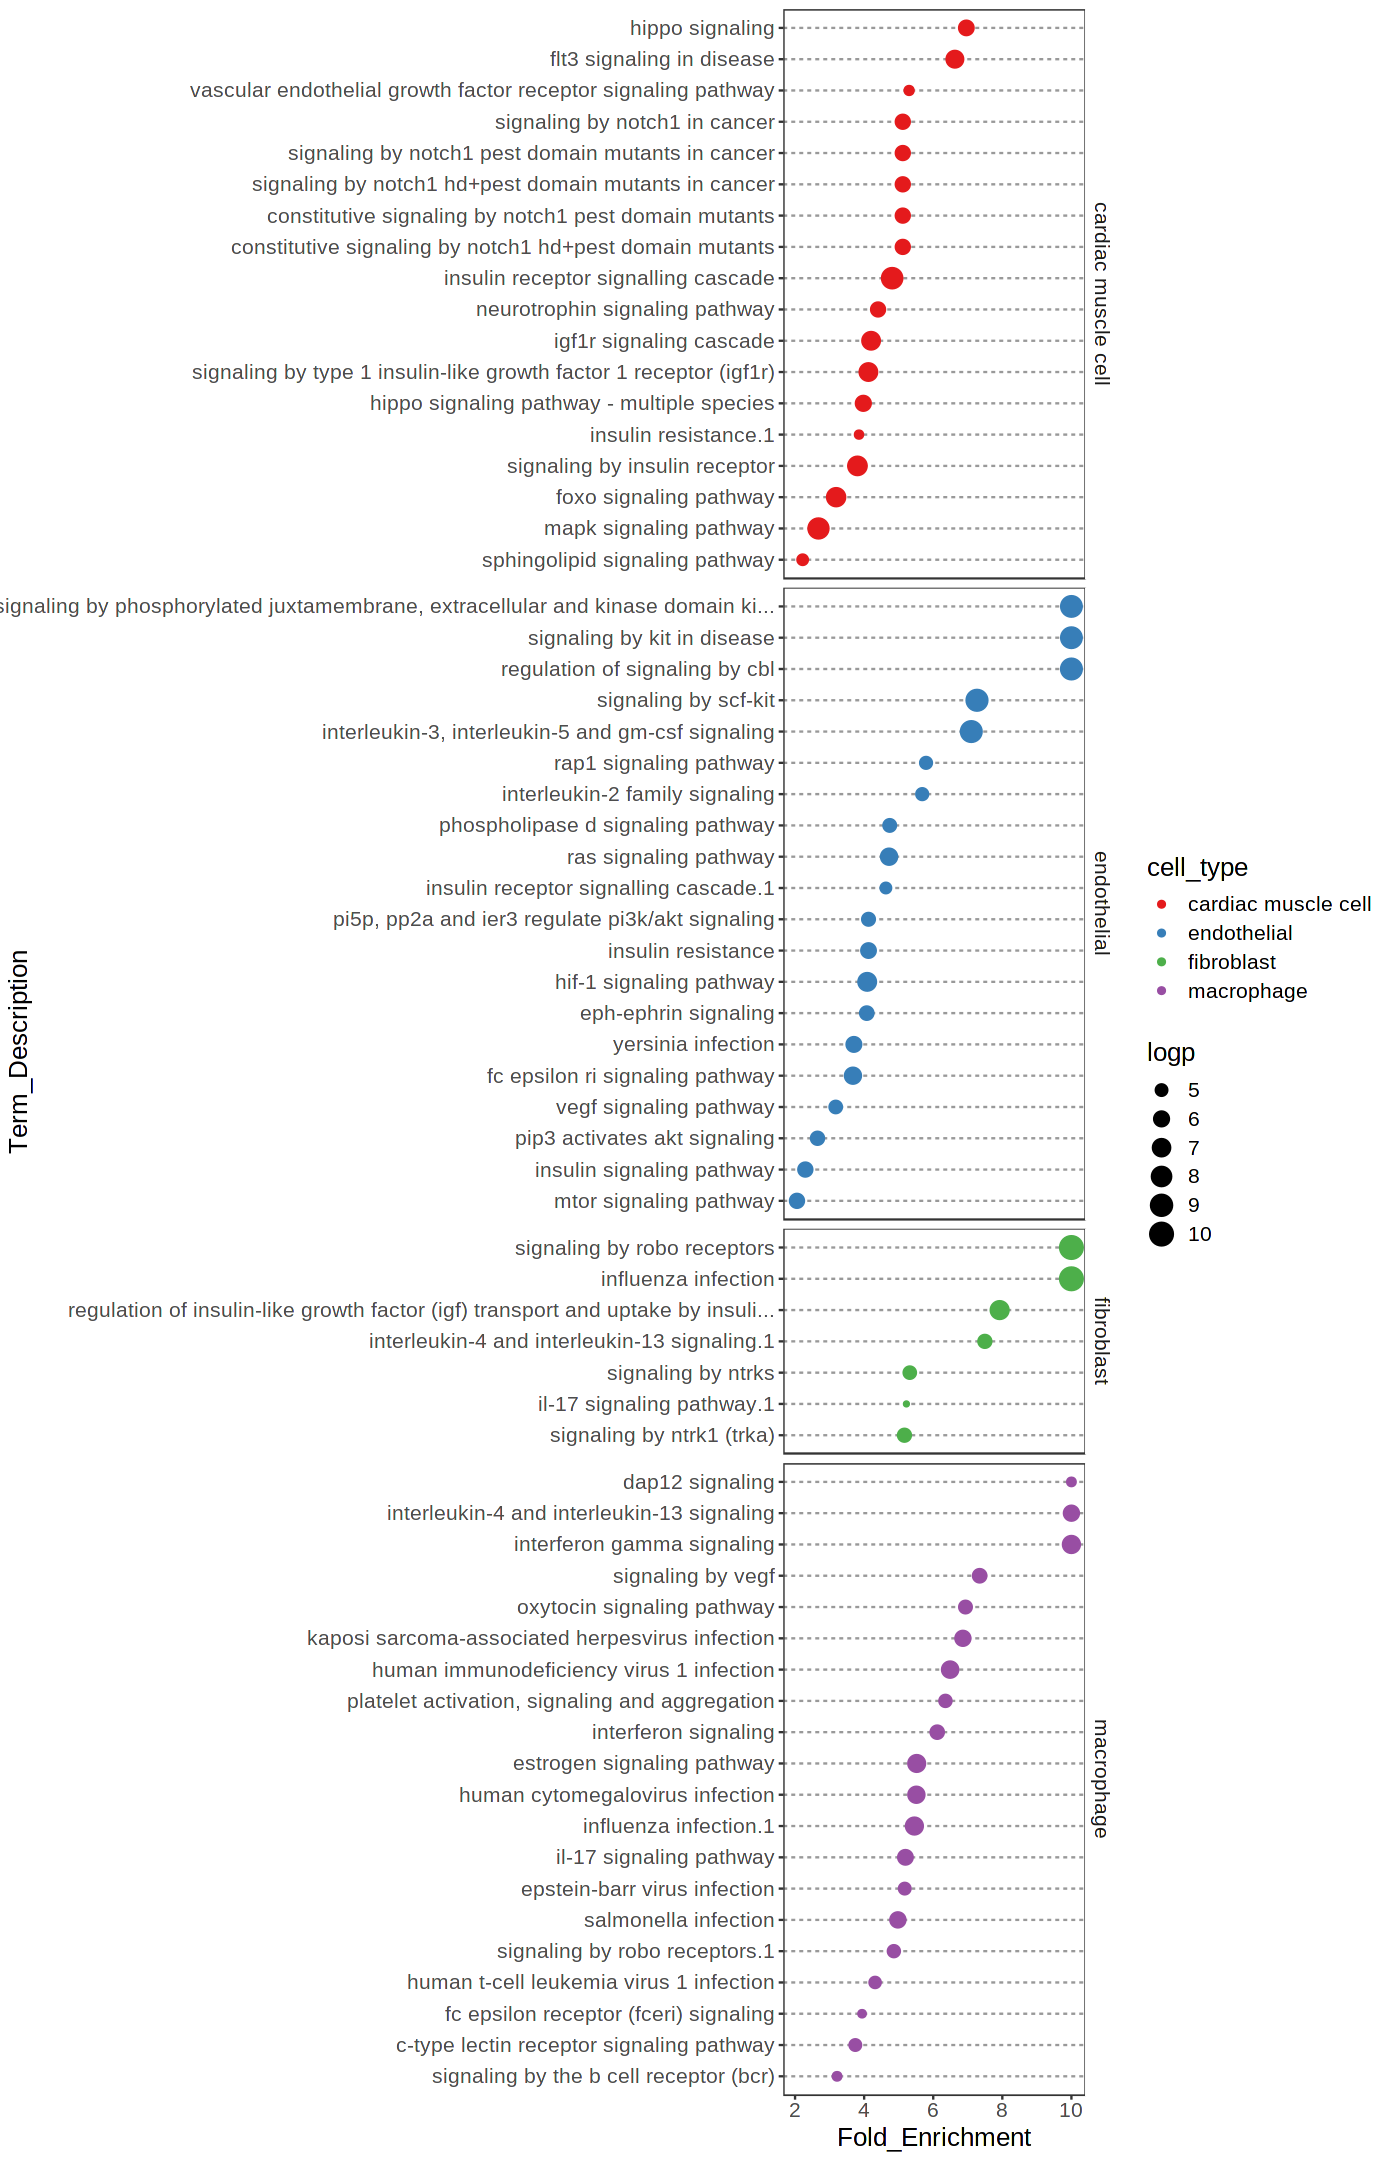

In [702]:
options(repr.plot.width=11.5, repr.plot.height=18)


raw_names <- ranked_paths_organ%>% pull(Term_Description) 

simple_names <- sapply(raw_names, function(x){
                                    if (grepl(x, pattern = "BIOCARTA")){ 
                                        return(str_split(x, "_", simplify= T)[-1] %>% paste(collapse = " ")) 
                                    }else{
                                        return(x)
                                    } } )
simple_names <- tolower(simple_names)
ranked_paths_organ$reference_pathway <- ranked_paths_organ$Term_Description
ranked_paths_organ$Term_Description <- simple_names

#term_grep_pattern = 'insulin|infection|signaling|wnt|catenin|foxo|notch|bmp|vegf|egf|gfg|eph|interleu|il-|'
term_grep_pattern = 'insulin|infection|signaling|wnt|catenin'

which_direction = 'up'
n_pathways = 20


pathway_hits <- ranked_paths_organ %>% dplyr::filter(grepl(Term_Description, pattern = term_grep_pattern, ignore.case =T)) %>% 
                    arrange(cell_type) %>%  dplyr::filter(n_genes_used > 2, highest_p < 1e-3) 

pathway_hits %>% plotTopPathwaysOrgan(max_logp=10, max_FC = 10,
                                      max_name_length = 80,
                                     min_pval = 0.0001)


ggsave(filename = paste0(FIG_DIR , this_sample, 'PathwaysUP_cov19.pdf'), width = 11.5, height = 18, dpi = 300)

## Heatmap 

In [703]:
organ_allupdown <- load_pathways_UpDown('heart')

#term_grep_pattern = 'insulin|infection|signaling|wnt|catenin|foxo|notch|bmp|vegf|egf|gfg|eph|interleu|il-|'
term_grep_pattern = 'insulin|infection|signaling'

which_direction = 'up'
n_pathways = 20


pathway_hits <- organ_allupdown %>% dplyr::filter(grepl(Term_Description, pattern = term_grep_pattern, ignore.case =T)) %>% 
                    arrange(cell_type) %>%  dplyr::filter(n_genes_used > 2, highest_p < 1e-3) 

In [737]:

# Read DGE results from MAST
DGE_FILE = '/mnt/ibm_lg/covid_tissue_atlas/results/DGE/MAST/all_celltypes_DGE_ngenescovar_Nov_MAST.csv'
dge_df = read.csv(DGE_FILE)

# In heart, remove neurons from final figure 
dge_df <- dge_df %>% dplyr::filter(cell_type !='neurons')

# Filter tissue and cell type of interest 
dge_df %>% filter(tissue == this_sample) -> tissue_df
#tissue_df$pval <- p.adjust(tissue_df$pval, method = 'bonferroni')
tissue_df %>% dplyr::filter(pval<0.0000001, abs(log2fc) >1 ) -> tissue_df

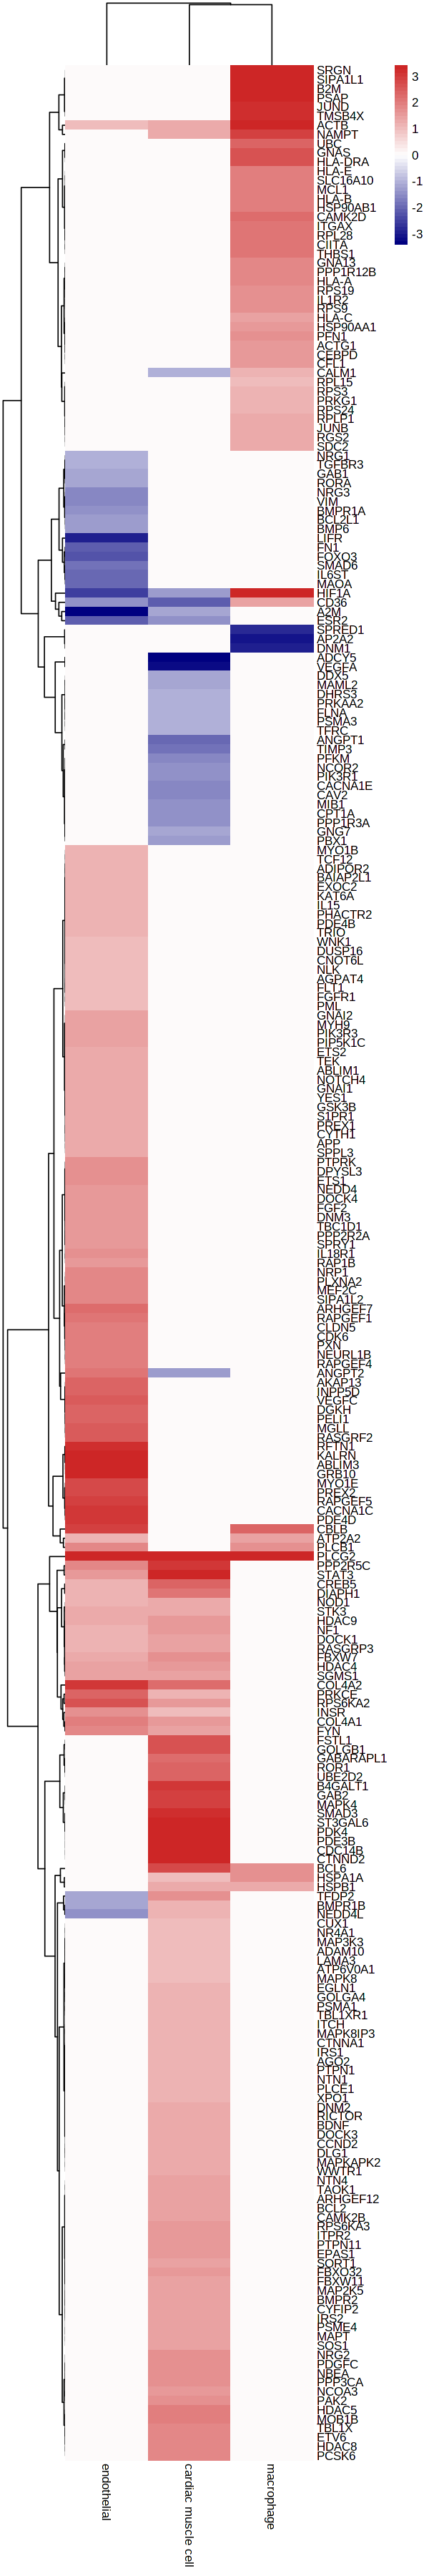

In [741]:
options(repr.plot.width=5, repr.plot.height=30)

select_celltypes = c('cardiac muscle cell','macrophage','endothelial') 

x<- getGeneListsOrgan(pathway_hits, tissue_df) 
x<- x[select_celltypes,]
x<- x[,colSums(abs(x))>0]

cutoff <- min(max(x), abs(min(x)))
x[x<-cutoff] <- -cutoff
x[x>cutoff] <- cutoff
p <- pheatmap(t(x),  col = colorRampPalette(c("navy", "white", "firebrick3"))(50), clustering_method = 'ward.D2')

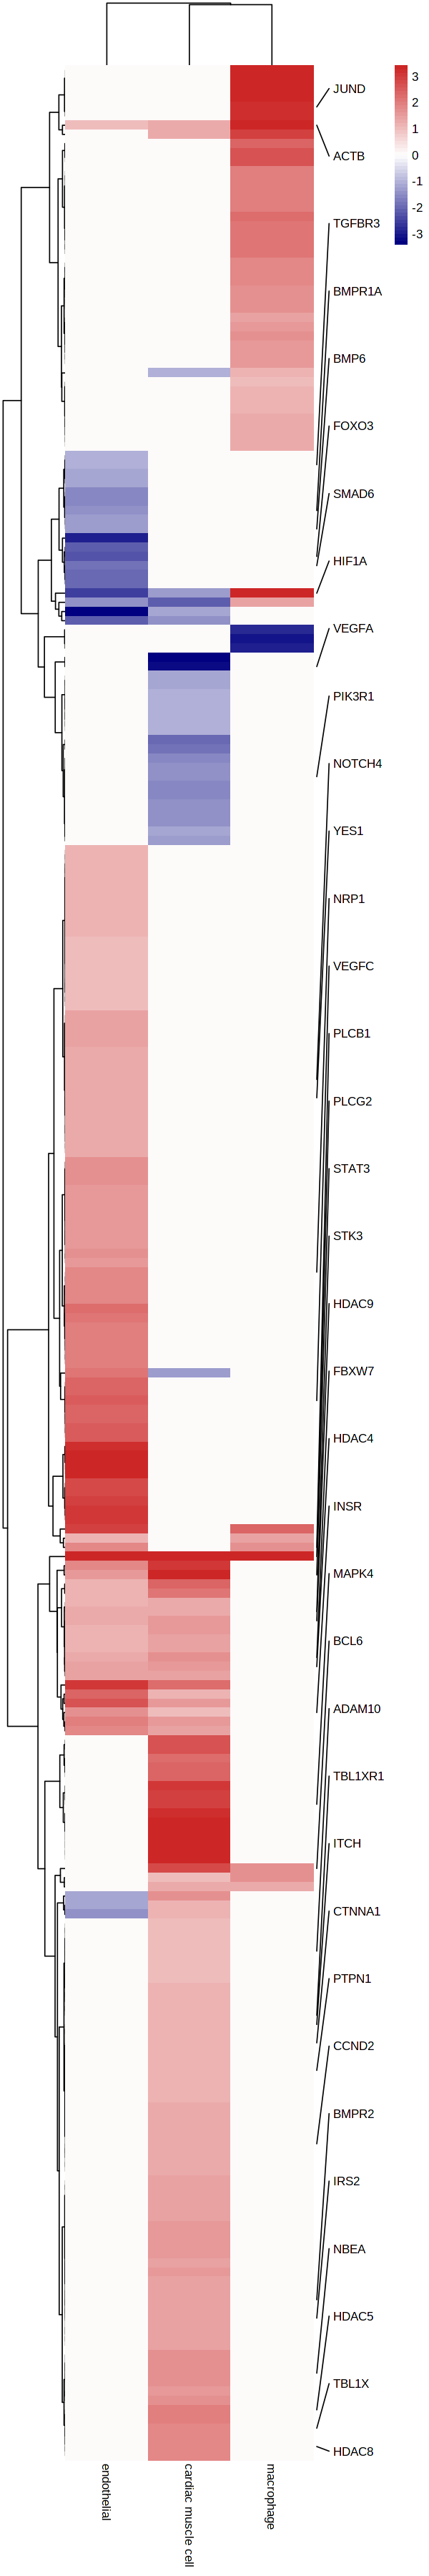

In [753]:
library(grid)
kept.labels = c('INSR','IGFBP1' ,'PRKAG2', 'MDM2', 'INSR', 'IRS2', 'PIK3CB', 
                'PIK3R1', 'FOXO1', 'FOXO3', 'STAT3', 'EGFR', 'MAP2K1', 'MAPK14', 'PCK1',
               'INSR', 'HK1', 'PRKAG2', 
                'RPS6', 'PTPN1',
               'TMPRSS2','EGFR', 'PLCG2', 'MAPK14', 'FOS', 'JUN', 'IFNAR1', 
                'C5AR1', 'CFB', 'C8G', 'MASP1', 'FGA', 'FGB', 'FGG', 
                'RAP1', 'VEGFC','NRP1','JUND','ACTB','MAPK4','PLCB1','INSR','SMAD6','FOXO3','HIF1A','VEGFA',
                'STAT3','TGFBR3','YES1','BCL6','BMPR1A','BMP6','NOTCH4','HDAC4','HDAC5','HDAC8',
               'FBXW7','ADAM10','HDAC9', 'ITCH', 'NBEA', 'TBL1X', 'TBL1XR1', #notch
               'STK3','BMPR2', 'CCND2', 'ACTB', 'CTNNA1') #hippo)
kept.labels = kept.labels[kept.labels %in% colnames(x)]
p1 = add.flag(p, kept.labels, 0.5)

In [754]:
ggsave(filename=paste(FIG_DIR, "heatmap_topgenesHeart.pdf", sep =""), plot=p1,
      width = 7, height = 20 )

In [745]:
tissue_df %>% dplyr::filter(grepl(gene,pattern = 'notch',ignore.case = T))

gene,pval,log2fc,cell_type,tissue,method,covariate
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
NOTCH4,1.050876e-09,1.361718,endothelial,heart,MAST,ngenes


In [752]:
pathway_hits %>% dplyr::filter(grepl(Term_Description,pattern = 'hippo',ignore.case = T))

Term_Description,cell_type,Fold_Enrichment,highest_p,support,database,n_genes_used,genes,logp,direction,reference_pathway
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<dbl>,<chr>,<chr>
hippo signaling pathway,cardiac muscle cell,2.703445,1.007202e-04,0.050506339,KEGG,11,"WWTR1, STK3, MOB1B, DLG1, FBXW11, SMAD3, BMPR1B, BMPR2, CCND2, ACTB, CTNNA1",3.996884,up,Hippo signaling pathway
hippo signaling pathway,endothelial,2.984868,3.535480e-06,0.005025126,KEGG,4,"BMP6, BMPR1A, BMPR1B, CCND3",5.451552,down,Hippo signaling pathway


### Experimental: Let's find the top terms for a given cell type
* For a given cell type, clean the text in the Terms (pathway names) from all databases 
* Separate Terms into single words and create frequency table
* Find the top keywords 
* Group the data by keyword and find summary statistics 

In [536]:
library(tidytext)

topTerms <- function(ranked_cell_type = data.frame() ){
    
    text_pathways <- ranked_cell_type %>% ungroup() %>%  select(Term_Description , database)

    remove_words <- c('endoplasmic','reticulum','formation','activate','receptor','transport',
                      'regulates','synthesis','assembly','signaling','signalling','regulation','binding','mediated','protein','pathway','positive','cell','membrane', 'cycle'
                     , 'mutants', 'activity', 'response', 'degradation', 'activity', 'cell', 'degradation', 'complex', 'cascade', 'expression', 'process', 'dependent'
                     , 'like', 'activation', 'negative', 'events')
    for(w in remove_words){
        text_pathways$Term_Description <- str_replace(text_pathways$Term_Description, w, "")
    }


    text_pathways <- text_pathways %>% rename(text = Term_Description, book = database) %>% 
                        mutate(line = 1:dim(text_pathways)[1])
    text_pathways$book <- as.factor(text_pathways$book )

    tidy_paths <- text_pathways %>%
      unnest_tokens(word, text)

    cleaned_paths <- tidy_paths %>%
      anti_join(get_stopwords())

    remove_words2<- c('s','ular','cancer','metabolism','acid','ing','associated','density','factor','entry',
                      'factors','interactions','gene','ligand','m','domain','1','d','er','signal', 'transcription',
                     'rna','mrna','class','early','nucleus','nuclear','localization','family','secretion',
                      'growth','plasma','type','ii','3','specific','particle','g1','g2','phase')
    cleaned_paths %>%  
      count(word, sort = TRUE) %>% dplyr::filter(n>5, !word %in% remove_words2)  -> top_words 
    
    return(top_words)
    
    
}

# we map the top terms to each pathway in the original data.frame 
assignKeyWords <- function(ranked_cell_type = data.frame() , top_words = data.frame() ){
    # Assign corresponding keywords to each pathway in the MAIN dataframe
    ranked_cell_type$key_words = ""
    i = 1
    aa <- ranked_cell_type 
    for(i in 1:dim(top_words)[1]){
        aa<- aa %>% 
            dplyr::mutate( key_words = ifelse(grepl(Term_Description,pattern =top_words$word[i]), paste(key_words,top_words$word[i] , sep =","), key_words ))

    }
    return(aa)
}

# based on keywords, we cluster the pathways and compute summary statistics for each pathway group/cluster
clusterKeywordSets <- function( all_pathways = data.frame() ,  top_words = data.frame() ,
                              min_gene_freq =0.3){
    
    clustered_pathways = data.frame() 
    for(this_set in top_words$word){
        all_pathways %>% ungroup %>% dplyr::filter(grepl(key_words, pattern = this_set)) %>% 
            distinct(genes, .keep_all = TRUE) -> keyword_set

        keyword_set %>% summarise( n_pathways = n(), FC = mean(Fold_Enrichment), max_pval = combine.test(highest_p, method = 'fisher'), 
                       n_genes = mean(n_genes_used), key_word = this_set ) -> group_stats 


        gene_lists <- keyword_set$genes

        all_genes <- str_split(paste(gene_lists, collapse =",", sep = "") , ",")[[1]] %>% trimws()

        jaccard_idx <- length(all_genes%>% unique) / length(all_genes) # fraction of unique genes / total genes in the pathway group
        group_stats$jaccard_idx <- jaccard_idx
        group_stats$n_genes <-length(all_genes%>% unique) # total unique genes in the patwhay group
        
        # intersection across ALL pathways: usually 0 
        a <- lapply(gene_lists, function(x){str_split(x,',', simplify = T)})
        group_stats$intersect_genes <- Reduce(intersect, a) %>% length() # overlapping genes across all pathways in the group 
        
        # using a table, we can count the N of genes that appear in a min fraction of all sets 
        gene_freqs <- sort(table(all_genes))/ group_stats$n_pathways
        group_stats$genes_minFrac <- sum(gene_freqs>min_gene_freq )
        
        group_stats$logp <- -log10(group_stats$max_pval)
        clustered_pathways =rbind(clustered_pathways, group_stats)
    }
    return(clustered_pathways )
}

Split into words, remove uninformative terms and create a fequency matrix

In [537]:
library(survcomp)
library(ggrepel)

topTermPipeline <- function(which_cell_type = "endothelial",ranked_paths_organ = data.frame()  ){
    
    cell_type_sets <- ranked_paths_organ %>% dplyr::filter(cell_type==which_cell_type)
    top_terms <- topTerms(ranked_cell_type = cell_type_sets)
    all_pathways <- assignKeyWords(ranked_cell_type =cell_type_sets, top_words = top_terms )
    clustered_pathways <- clusterKeywordSets( all_pathways  ,  top_words = top_terms )
    clustered_pathways$cell_type = which_cell_type
    return(clustered_pathways )
}

plotTopTerms <-function(clustered_pathways = data.frame(), which_cell_type = "endothelial", 
                        max_logp  = 40 , min_genes = 8, min_FC = 2, min_jac = 0.4){
    clustered_pathways$logp[clustered_pathways$logp>max_logp] <- max_logp

    p1 <- clustered_pathways %>% dplyr::filter(n_genes >min_genes, FC > min_FC , jaccard_idx> min_jac) %>% 
        ggplot(aes(x = logp , y = n_genes /n_pathways, size = FC, label = key_word))+ 
        geom_point() + theme_minimal() + geom_text_repel(size = 5) + 
        theme(text = element_text(size = 12)) + ggtitle(which_cell_type)
    return(p1)
}

In [538]:
all_celltypes = data.frame() 
for(ct in c('macrophage', 'endothelial', 'hepatocyte')){
    grouped_genesets <- topTermPipeline( which_cell_type =ct, ranked_paths_organ)
    all_celltypes <- rbind(all_celltypes, grouped_genesets)
    }

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"



Warning message:
“ggrepel: 11 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


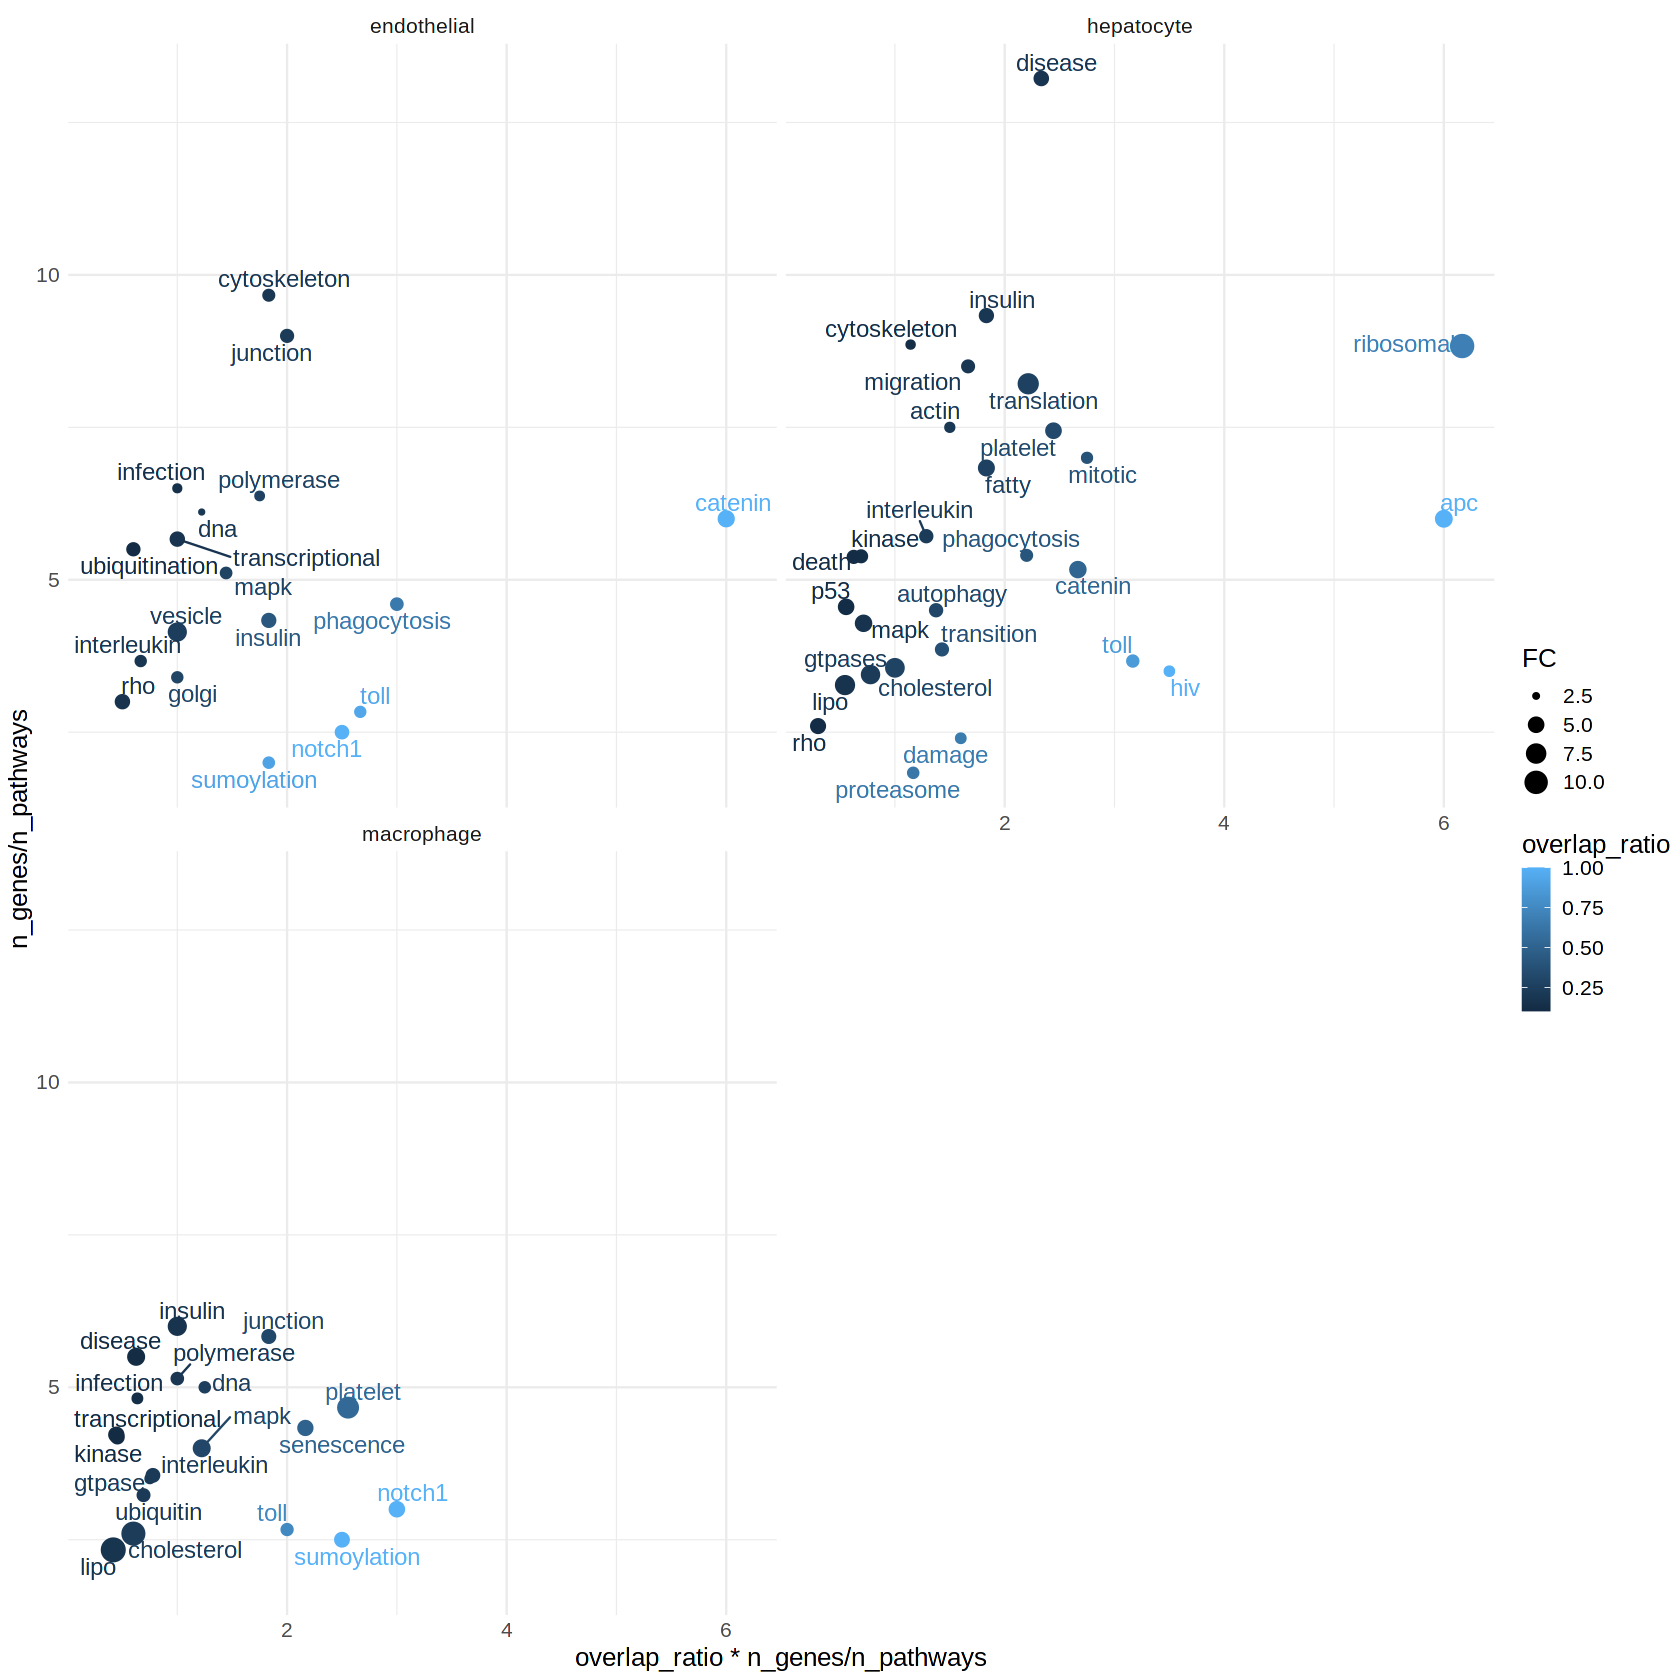

In [541]:
options(repr.plot.width=14, repr.plot.height=14)


all_celltypes$logp[all_celltypes$logp>max_logp] <- max_logp
min_genes = 8 
min_FC = 2
min_jac = 0.1
    all_celltypes <- all_celltypes %>% mutate(overlap_ratio = genes_minFrac/n_genes)
    plot_celltypes <- all_celltypes %>% dplyr::filter(overlap_ratio > 0.1) 

    p1 <- plot_celltypes %>% dplyr::filter(n_genes >min_genes, FC > min_FC , jaccard_idx> min_jac) %>% 
        ggplot(aes(x = overlap_ratio*n_genes/n_pathways , y = n_genes /n_pathways, size = FC, label = key_word, color = overlap_ratio))+ 
        geom_point() + theme_minimal() +theme(text = element_text(size = 15)) + geom_text_repel(size = 5) + 
          facet_wrap(~ cell_type, ncol = 2)
p1

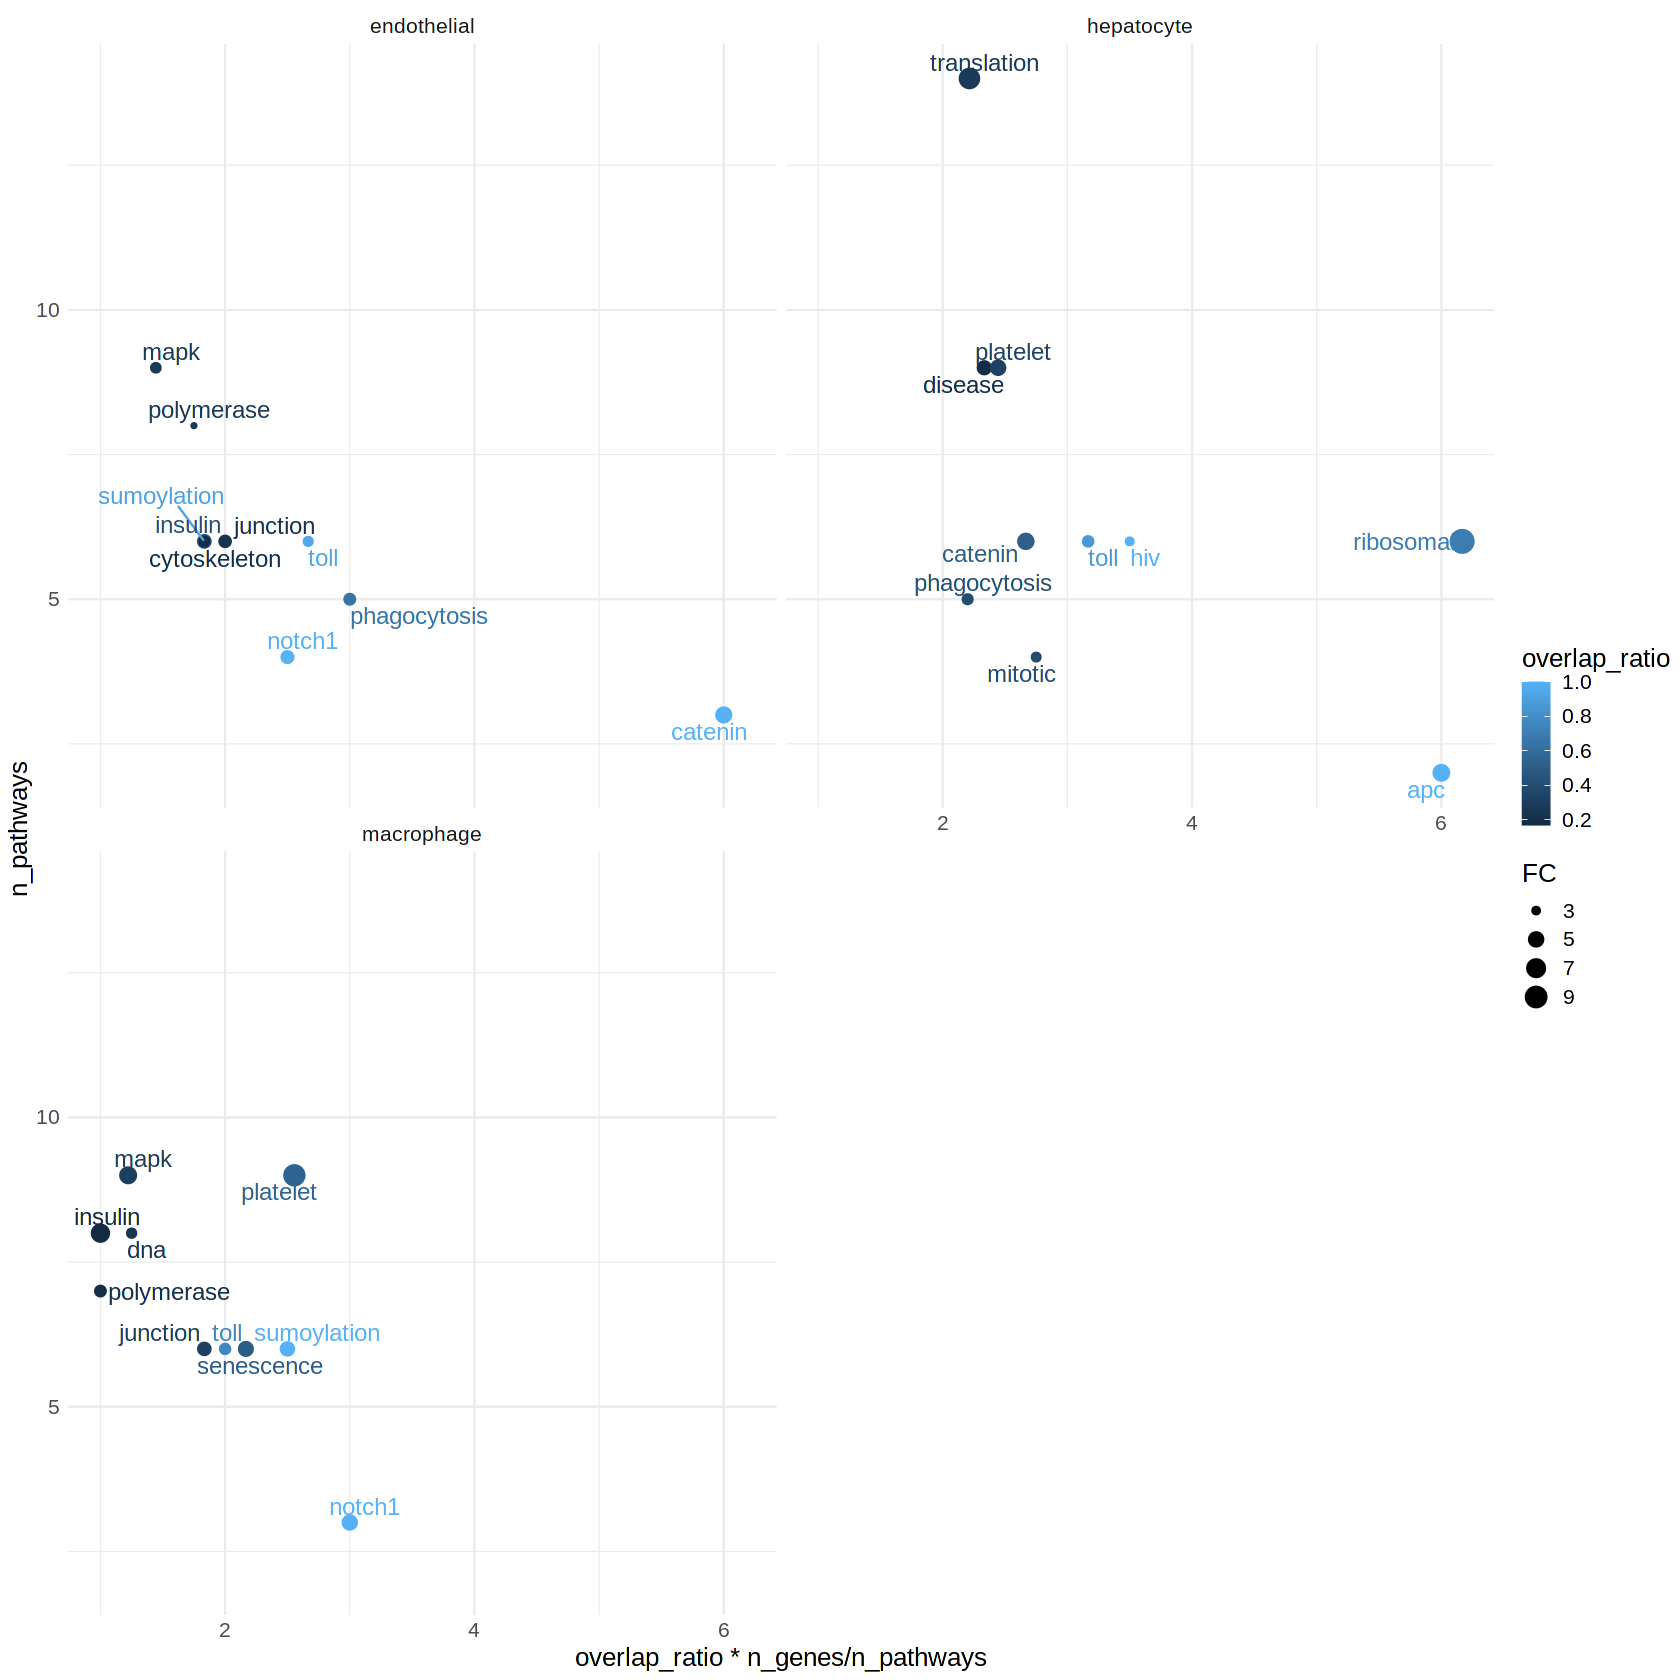

In [546]:
plot_celltypes %>% dplyr::filter(n_genes >min_genes, FC > min_FC , jaccard_idx> min_jac) %>%
    group_by(cell_type) %>% top_n(10, wt = overlap_ratio*n_genes/n_pathways) %>% arrange(cell_type, desc(logp)) %>% 
    ggplot(aes(x = overlap_ratio*n_genes/n_pathways , y = n_pathways, size = FC, label = key_word, color = overlap_ratio))+ 
        geom_point() + theme_minimal() +theme(text = element_text(size = 15)) + geom_text_repel(size = 5) + 
          facet_wrap(~ cell_type, ncol = 2)

In [471]:
gene_lists %>% length() 

[1] 6

In [474]:
Reduce(intersect, list(c('a'), c('a','b') ,c('c','a') ))

[1] "a"

[1] "EIF1AX"